In [25]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

In MRI and MRS, we constantly move between the time domain and frequency domain, or between $k$-space and image space.

While `numpy.fft` is incredibly fast, applying it directly to physical data is notoriously finicky: it places the zero-frequency (DC) component at the edges, requiring manual `fftshift` operations, and it scales the signal amplitude by the number of points, breaking energy conservation (Parseval's theorem) between domains.

The `xmris` Fourier module provides a mathematically rigorous, `xarray`-native toolbox to solve these issues. It handles orthogonal normalization, coordinate math, and shifting automatically.

## Overview of Available Functions

The module provides three pairs of functions to handle any transformation scenario:

1. **Pure Transforms (`fft` / `ifft`):**

    Performs orthogonal, N-dimensional transforms with **no** shifting. Perfect for signals that strictly start at $t=0$.

2. **Explicit Shifts (`fftshift` / `ifftshift`):**

    Safely rolls both the data matrix *and* the coordinate axes, keeping physical labels perfectly aligned with the data.

3. **Centered Transforms (`fftc` / `ifftc`):**

    Convenience wrappers for symmetrically sampled data (like imaging). It chains shifts *before* and *after* the transform to keep the zero-frequency component dead center.

```mermaid
flowchart TD
    subgraph Centered Transform
        D2[(Input Data)] --> S1[ifftshift] --> F2[xmris.fft] --> S2[fftshift] --> O2[(Centered Output)]
    end
```

:::{dropdown} Under the Hood: No Magic Strings
As a user, you can pass simple strings like `"time"` and `"frequency"` to `xmris` functions. However, internally, the package never uses raw strings. It maps your input to a strict global vocabulary (`xmris.core.config.DIMS` and `COORDS`).

This architecture allows `xmris` to intercept your request and automatically inject physical metadata (like setting the new coordinate units to `Hz` or `s`) without you ever having to ask for it!

For more info see [xmris Architecture: Why We Built It This Way](./architecture.ipynb)
:::

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xmris  # Registers the .xmr accessor

---

## 1. 1D Signal: Time Domain to Frequency Domain

Let's generate a simple, synthetic time-domain signal: a decaying sine wave with a 50 Hz frequency offset.

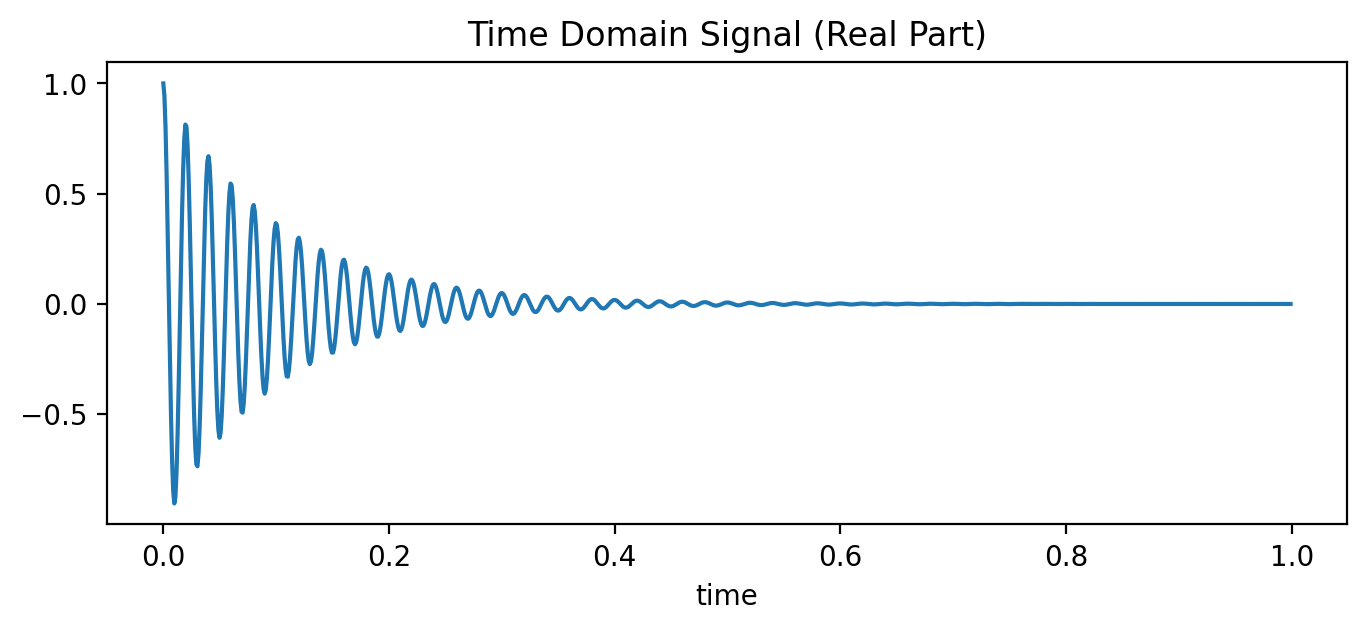

In [ ]:
# Create a synthetic 1D signal (Time domain)
t = np.linspace(0, 1, 1024, endpoint=False)
fid_data = np.exp(-t / 0.1) * np.exp(1j * 2 * np.pi * 50.0 * t)

da_fid = xr.DataArray(
    fid_data,
    dims=["time"],
    coords={"time": t},)

# Plot the real part
fig, ax = plt.subplots(figsize=(8, 3))
da_fid.real.plot(ax=ax)
ax.set_title("Time Domain Signal (Real Part)")
plt.show()

Now, we apply the Fourier transform.

**Crucial detail:** Because this specific signal starts exactly at $t=0$, we *cannot* use the centered wrapper `fftc`. Applying an `ifftshift` to the input would physically split our $t=0$ data point and move it to the center of the array, completely destroying the signal phase.

Instead, we use the pure `.xmr.fft()` followed by an explicit `.xmr.fftshift()`. By providing `out_dim="frequency"`, the toolbox automatically calculates the reciprocal coordinate values (Hz) based on the input dwell time and renames the dimension for us.

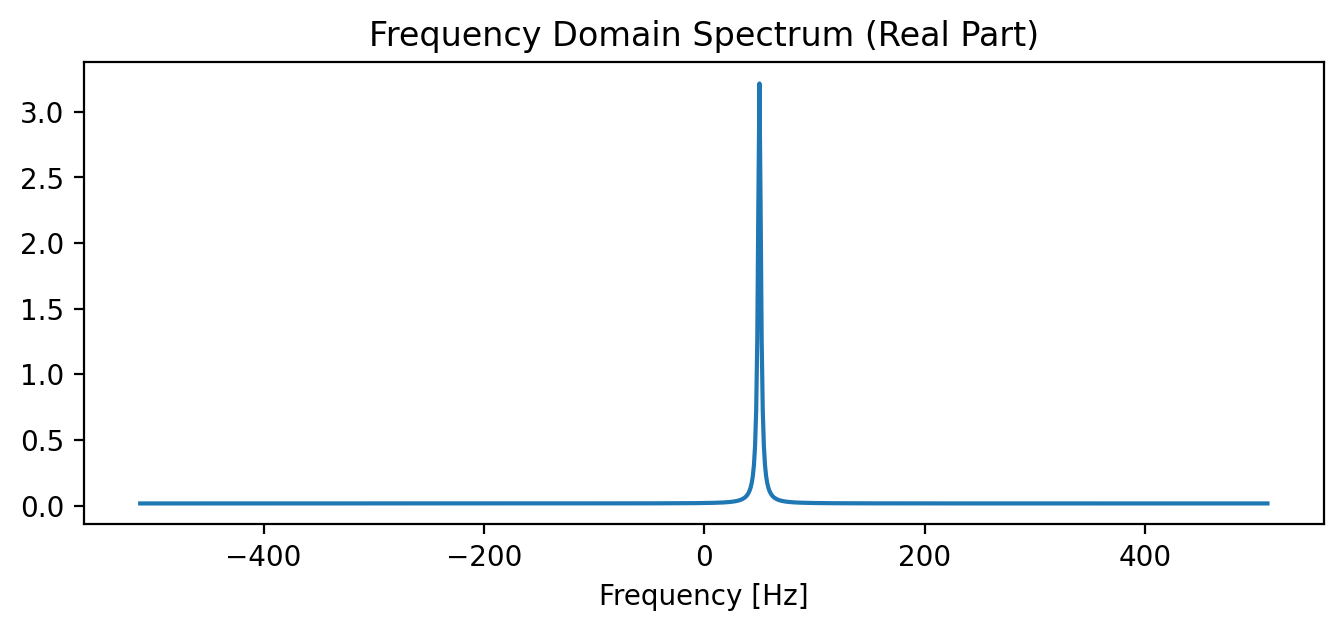

In [28]:
# Transform to Frequency Domain, calculate Hz axis, and center the output
da_spectrum = (
    da_fid
    .xmr.fft(dim="time", out_dim="frequency")
    .xmr.fftshift(dim="frequency")
)

# Plot the real part of the spectrum
fig, ax = plt.subplots(figsize=(8, 3))
da_spectrum.real.plot(ax=ax)
ax.set_title("Frequency Domain Spectrum (Real Part)")
plt.show()

In [ ]:
# --- AUTOMATED TESTS (Pytest-nbmake) ---
# This cell is hidden in the MyST docs but executed in CI.

# 1. Metadata Preservation & Coordinate Transformation
assert "frequency" in da_spectrum.dims, "Dimension was not renamed!"
assert "time" not in da_spectrum.dims
assert da_spectrum.coords["frequency"].attrs.get("units") == "Hz", "Units were not injected!"

# 2. Check the Math (Is the peak actually at 50 Hz?)
peak_idx = np.argmax(np.abs(da_spectrum.values))
peak_freq = da_spectrum.coords["frequency"].values[peak_idx]
assert np.isclose(peak_freq, 50.0), f"Peak is at {peak_freq} Hz, expected 50 Hz!"

# 3. Parseval's Theorem (Energy Conservation via Ortho Normalization)
energy_time = np.sum(np.abs(da_fid.values) ** 2)
energy_freq = np.sum(np.abs(da_spectrum.values) ** 2)
assert np.isclose(energy_time, energy_freq), "FFT energy conservation failed!"

---

## 2. Imaging: 2D $k$-space to Image Space

The true power of `xarray` + `xmris` shines in multi-dimensional data. Let's create a synthetic 2D $k$-space using custom dimension strings (`"kx"` and `"ky"`). We will use a simple 2D rectangle, which analytically transforms into a 2D sinc function in the image domain.

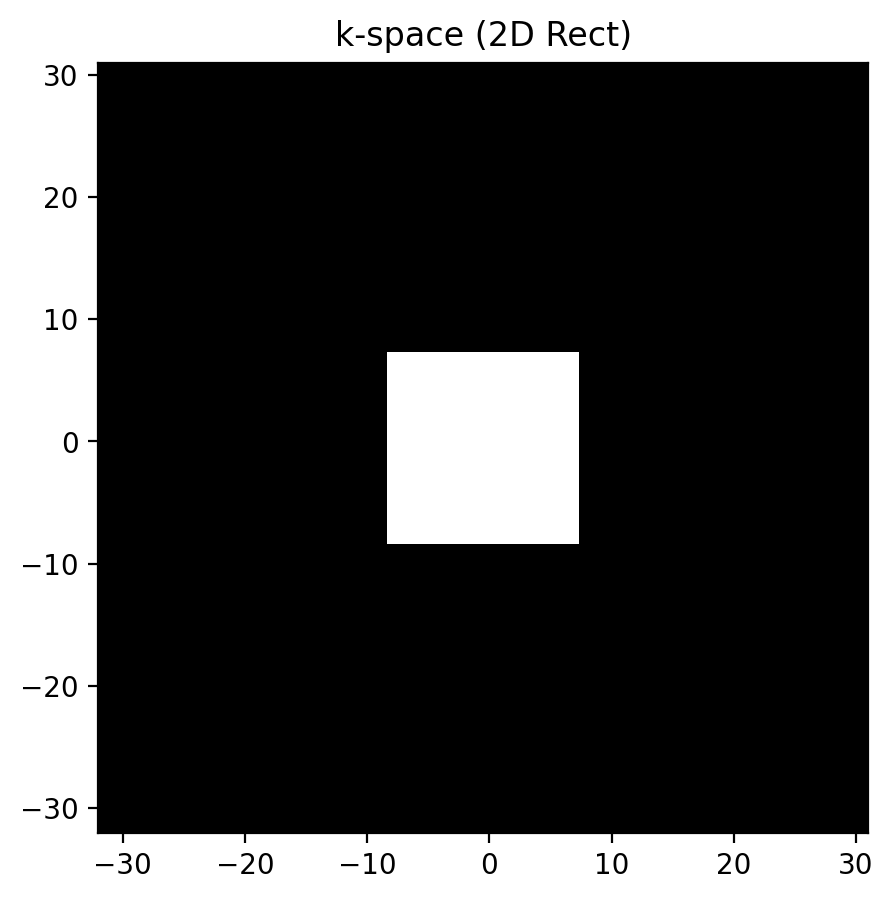

In [30]:
# Create a synthetic 2D k-space (64x64 matrix)
kspace_data = np.zeros((64, 64), dtype=complex)
kspace_data[24:40, 24:40] = 1.0  # 16x16 rect in the center

da_kspace = xr.DataArray(
    kspace_data,
    dims=["kx", "ky"],
    coords={"kx": np.linspace(-32, 31, 64), "ky": np.linspace(-32, 31, 64)},
)

# Plot k-space magnitude
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.abs(da_kspace.values), cmap="gray", extent=[-32, 31, -32, 31])
ax.set_title("k-space (2D Rect)")
plt.show()

Unlike the 1D signal starting at $t=0$, imaging data is symmetrically sampled around the center of $k$-space. To transform this correctly, we *must* shift the input before the transform, and shift the output after.

We use the convenience wrapper `.xmr.ifftc()` to handle these shifts automatically. By passing a **list of dimensions**, we perform a 2D inverse Fourier transform and seamlessly map `["kx", "ky"]` to `["x", "y"]` in a single line.

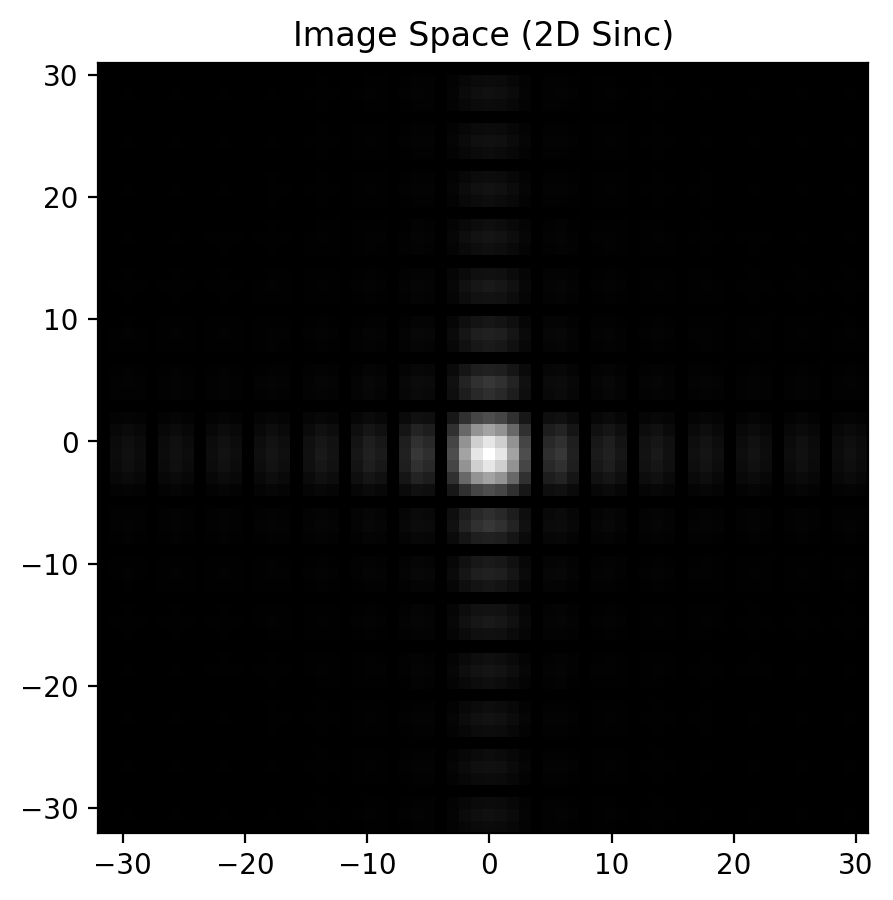

In [31]:
# Transform to Image Domain (2D IFFT with symmetric shifts) and rename dimensions
da_image = da_kspace.xmr.ifftc(dim=["kx", "ky"], out_dim=["x", "y"])

# Plot image domain magnitude
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.abs(da_image.values), cmap="gray", extent=[-32, 31, -32, 31])
ax.set_title("Image Space (2D Sinc)")
plt.show()

In [32]:
# --- AUTOMATED TESTS (Pytest-nbmake) ---
# This cell is hidden in the MyST docs but executed in CI.

# 1. Coordinate mapping
assert da_image.dims == ("x", "y"), "Dimensions were not renamed to x and y!"
assert da_image.attrs["ifft_applied"] is True, "Lineage attribute missing!"

# 2. Centering Test
# Ensure the peak of the 2D Sinc is exactly in the center (index 32, 32)
peak_idx = np.unravel_index(np.argmax(np.abs(da_image.values)), da_image.shape)
assert peak_idx == (32, 32), "Image is not centered!"

# 3. Round-Trip Reversibility (IFFT -> FFT should yield original k-space)
da_reconstructed = da_image.xmr.fftc(dim=["x", "y"], out_dim=["kx", "ky"])
assert da_reconstructed.dims == ("kx", "ky"), "Dimensions did not revert to kx, ky!"
assert np.allclose(da_kspace.values, da_reconstructed.values), (
    "Round-trip transformation failed!"
)